The purpose of this notebook effect of quantization on the performance when training a simple neural network performing classifaction (fully connected) The neural network can be parametrizeed by the number of layers, activation function, number of nodes per layer. Then, using a simple synthetic data set consisting of 2 possible choices-- bimodal guassian and spiral. Compute the effect of quantization on performance. The training of the model is done with fp32 and fp16. fp16 is done using PyTorch's .half() method.

imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

seeds

In [2]:

import random # Import the random module

def set_seed(seed_value):
    """Set seed for reproducibility across different libraries."""
    random.seed(seed_value) # Python's built-in random
    np.random.seed(seed_value) # NumPy
    torch.manual_seed(seed_value) # PyTorch CPU

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value) # PyTorch CUDA single GPU
        torch.cuda.manual_seed_all(seed_value) # PyTorch CUDA multi-GPU
        # Optional: Enable deterministic operations on CUDA. Can have a performance impact.
        # Some operations are not deterministic even with seeds without these lines.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False # Setting benchmark to False is often recommended with deterministic=True



# Choose a seed value - any integer works
SEED = 42
set_seed(SEED)





configuration in a dict

In [3]:
# Configuration parameters
# Existing config dictionary
config = {
    'num_layers': 3,
    'activation_function': 'relu',
    'nodes_per_layer': 4,
    'dataset_type': 'spiral', # or 'spiral'
    'num_training_samples': 1000,
    'num_testing_samples': 1000,
    'epochs': 100,
    'batch_size': 8,
    'learning_rate': 0.03,
    'precision': 'fp32' # Added precision to config
}

this is a simple UI to capture the config

In [4]:
from IPython.display import display
import ipywidgets as widgets




# Create widgets for each configuration parameter

# Number of layers slider
num_layers_slider = widgets.IntSlider(
    min=1,
    max=10,
    step=1,
    description='Number of Layers:',
    value=config['num_layers'],
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Nodes per layer slider
nodes_per_layer_slider = widgets.IntSlider(
    min=1,
    max=256,
    step=16,
    description='Nodes per Layer:',
    value=config['nodes_per_layer'],
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Dataset type dropdown
dataset_type_dropdown = widgets.Dropdown(
    options=['bimodal_gaussian', 'spiral'],
    value=config['dataset_type'],
    description='Dataset Type:',
)

# Number of training samples text box
num_training_samples_text = widgets.IntText(
    description='Number of Training Samples:',
    value=config['num_training_samples'],
)
# Number of testing samples text box
num_testing_samples_text = widgets.IntText(
    description='Number of Testing Samples:',
    value=config['num_testing_samples'],
)
# Batch size dropdown
batch_size_dropdown = widgets.Dropdown(
    options=[4, 8, 16, 32],
    value=config['batch_size'],
    description='Batch Size:',
)

# Learning rate text box
learning_rate_text = widgets.FloatText(
    description='Learning Rate:',
    value=config['learning_rate'],
)

# Precision dropdown
precision_dropdown = widgets.Dropdown(
    options=['fp32', 'fp16'],
    value=config['precision'],
    description='Precision:',
)

# Button to register settings
register_button = widgets.Button(description="Register Settings")

# Output widget to display the config
output_widget = widgets.Output()

# Function to update config and display it
def register_settings(b):
    # Update config dictionary with selected values
    config['num_layers'] = num_layers_slider.value
    config['nodes_per_layer'] = nodes_per_layer_slider.value
    config['dataset_type'] = dataset_type_dropdown.value
    config['num_training_samples'] = num_training_samples_text.value
    config['num_testing_samples'] = num_testing_samples_text.value
    config['batch_size'] = batch_size_dropdown.value
    config['learning_rate'] = learning_rate_text.value
    config['precision'] = precision_dropdown.value

    # Clear previous output and display the updated config
    with output_widget:
        output_widget.clear_output()
        print("Updated Configuration Dictionary:")
        print(config)

# Link the button click event to the function
register_button.on_click(register_settings)

# Arrange widgets and button in a VBox
ui = widgets.VBox([
    num_layers_slider,
    nodes_per_layer_slider,
    dataset_type_dropdown,
    num_training_samples_text,
    num_testing_samples_text,
    batch_size_dropdown,
    learning_rate_text,
    precision_dropdown,
    register_button,
    output_widget # Include the output widget in the layout
])

# Display the UI
display(ui)

create data

In [5]:


def create_dataset(dataset_type, num_samples):
    if dataset_type == 'bimodal_gaussian':
        n = num_samples // 2  # Split samples equally between the two Gaussians

        # Gaussian 1: centered at [-1, -1] with identity covariance (unit variance)
        mean1 = [-2, -2]
        cov1 = [[1, 0], [0, 1]]
        X1 = np.random.multivariate_normal(mean1, cov1, n)
        y1 = np.zeros(n)

        # Gaussian 2: centered at [1, 1] with identity covariance (unit variance)
        mean2 = [2, 2]
        cov2 = [[1, 0], [0, 1]]
        X2 = np.random.multivariate_normal(mean2, cov2, n)
        y2 = np.ones(n)

        X = np.vstack([X1, X2])
        y = np.hstack([y1, y2])

    elif dataset_type == 'spiral':
        n = num_samples // 2
        theta = np.linspace(0, 2 * np.pi, n) + np.random.randn(n) * 0.1
        r = np.linspace(0, 1, n)
        X1 = np.vstack([r * np.cos(theta), r * np.sin(theta)]).T
        y1 = np.zeros(n)

        theta = np.linspace(0, 2 * np.pi, n) + np.random.randn(n) * 0.1 + np.pi
        r = np.linspace(0, 1, n)
        X2 = np.vstack([r * np.cos(theta), r * np.sin(theta)]).T
        y2 = np.ones(n)

        X = np.vstack([X1, X2])
        y = np.hstack([y1, y2])
    else:
        raise ValueError("Invalid dataset type")
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


display training data (bimodal gaussian or spiral)

In [6]:
def display_data(X, y, dataset_type):
    """
    Displays the generated synthetic data.

    Args:
        X (torch.Tensor): The input features.
        y (torch.Tensor): The corresponding labels.
        dataset_type (str): The type of dataset ('bimodal_gaussian' or 'spiral').
    """
    X_np = X.numpy()
    y_np = y.numpy()

    plt.figure(figsize=(6, 6))
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='viridis', s=10)
    plt.title(f'{dataset_type.replace("_", " ").title()} Dataset')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Class')
    plt.grid(True)
    plt.show()

create train data

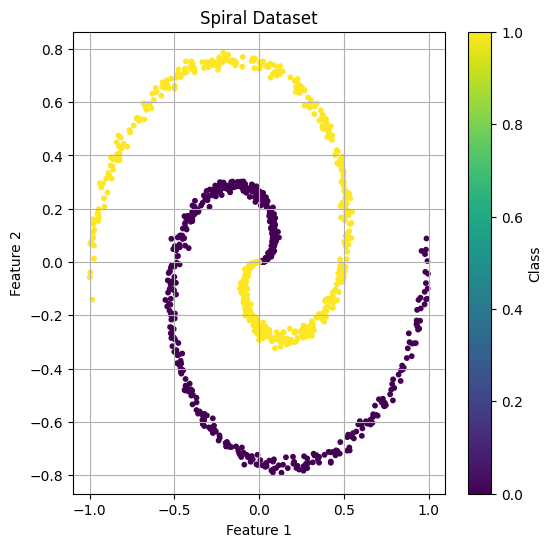

In [7]:
X_train, y_train = create_dataset(config['dataset_type'], config['num_training_samples'])
display_data(X_train, y_train, config['dataset_type'])

create test data


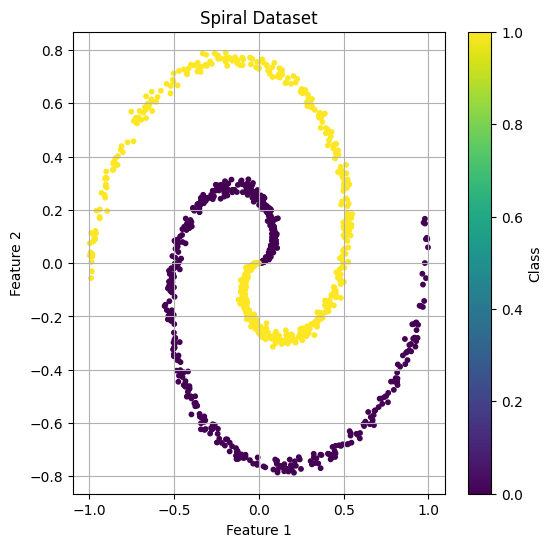

In [8]:
# Create testing data
X_test, y_test = create_dataset(config['dataset_type'], config['num_testing_samples'])
display_data(X_test, y_test, config['dataset_type'])

dataset and dataloader for train and test

In [9]:
# Custom Dataset
class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset_train = ClassificationDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=config['batch_size'], shuffle=True)

dataset_test = ClassificationDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=config['batch_size'], shuffle=True)


define linear NN

In [10]:

# Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_layers, nodes_per_layer, activation_function):
        super(SimpleNN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, nodes_per_layer))
        if activation_function == 'relu':
            layers.append(nn.ReLU())
        elif activation_function == 'tanh':
            layers.append(nn.Tanh())
        else:
            raise ValueError("Invalid activation function")

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(nodes_per_layer, nodes_per_layer))
            if activation_function == 'relu':
                layers.append(nn.ReLU())
            elif activation_function == 'tanh':
                layers.append(nn.Tanh())
            else:
                raise ValueError("Invalid activation function")

        layers.append(nn.Linear(nodes_per_layer, 2)) # Output layer for 2 classes
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)



Trains model using either fp32 or fp16
Has no option for gradient scaling so the fp16-trained model has loss of NaN

In [11]:
# Training function with explicit device placement
def train_model(model, dataloader, epochs, learning_rate, dtype):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Get the device (consistent with mixed precision function)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to the correct device AND dtype
    model.to(device=device, dtype=dtype)

    for epoch in range(epochs):
        for inputs, labels in dataloader:
            # Move inputs and labels to the correct device AND dtype
            # Note: Labels are usually torch.long for CrossEntropyLoss, so only inputs need dtype casting
            inputs, labels = inputs.to(device=device, dtype=dtype), labels.to(device=device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Print statement for loss per epoch
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')


for sanity check .. not to include in final code

In [12]:
model_fp32 = SimpleNN(input_dim=2, **{k: config[k] for k in ['num_layers', 'nodes_per_layer', 'activation_function']})
print("Training with FP32:")
train_model(model_fp32, dataloader_train, config['epochs'], config['learning_rate'], torch.float32)

Training with FP32:
Epoch 1/100, Loss: 0.7148
Epoch 2/100, Loss: 0.6537
Epoch 3/100, Loss: 0.6579
Epoch 4/100, Loss: 0.5085
Epoch 5/100, Loss: 0.8453
Epoch 6/100, Loss: 0.3313
Epoch 7/100, Loss: 0.0817
Epoch 8/100, Loss: 0.1421
Epoch 9/100, Loss: 0.3622
Epoch 10/100, Loss: 0.3117
Epoch 11/100, Loss: 0.2643
Epoch 12/100, Loss: 0.0662
Epoch 13/100, Loss: 0.1689
Epoch 14/100, Loss: 0.1676
Epoch 15/100, Loss: 0.3663
Epoch 16/100, Loss: 0.3091
Epoch 17/100, Loss: 0.2453
Epoch 18/100, Loss: 0.3409
Epoch 19/100, Loss: 0.5121
Epoch 20/100, Loss: 0.2583
Epoch 21/100, Loss: 0.7695
Epoch 22/100, Loss: 0.0061
Epoch 23/100, Loss: 0.0545
Epoch 24/100, Loss: 0.1957
Epoch 25/100, Loss: 0.1342
Epoch 26/100, Loss: 0.2263
Epoch 27/100, Loss: 0.2638
Epoch 28/100, Loss: 0.4025
Epoch 29/100, Loss: 0.1584
Epoch 30/100, Loss: 0.0355
Epoch 31/100, Loss: 0.1407
Epoch 32/100, Loss: 0.2043
Epoch 33/100, Loss: 0.3511
Epoch 34/100, Loss: 0.2844
Epoch 35/100, Loss: 0.0920
Epoch 36/100, Loss: 0.2788
Epoch 37/100, Los

Mixed precision training or full precision- can choose to implement gradient scaling or not

In [13]:
import torch
print(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

cpu


In [14]:
import torch.cuda.amp as amp
import torch

# Training function
def train_model_mixed(model, dataloader, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Get the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Move model to the correct device
    model.to(device)

    scaler = amp.GradScaler()

    for epoch in range(epochs):
        for inputs, labels in dataloader:
            # Move inputs and labels to the correct device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        #  print statement for loss here
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Training model with mixed precision

In [15]:
print("Mixed-precision training")
model_mixed = SimpleNN(input_dim=2, **{k: config[k] for k in ['num_layers', 'nodes_per_layer', 'activation_function']})
train_model_mixed(model_mixed, dataloader_train, config['epochs'], config['learning_rate'])



Mixed-precision training


<ipython-input-14-310e1e9d7ce4>:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-14-310e1e9d7ce4>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/100, Loss: 0.5153
Epoch 2/100, Loss: 0.5939
Epoch 3/100, Loss: 0.3339
Epoch 4/100, Loss: 0.4299
Epoch 5/100, Loss: 0.3549
Epoch 6/100, Loss: 0.8001
Epoch 7/100, Loss: 0.2621
Epoch 8/100, Loss: 0.0142
Epoch 9/100, Loss: 0.3327
Epoch 10/100, Loss: 0.4566
Epoch 11/100, Loss: 0.0177
Epoch 12/100, Loss: 0.0060
Epoch 13/100, Loss: 0.0314
Epoch 14/100, Loss: 0.0136
Epoch 15/100, Loss: 0.0017
Epoch 16/100, Loss: 0.0074
Epoch 17/100, Loss: 0.0119
Epoch 18/100, Loss: 0.4371
Epoch 19/100, Loss: 0.0076
Epoch 20/100, Loss: 0.0177
Epoch 21/100, Loss: 0.0108
Epoch 22/100, Loss: 0.0973
Epoch 23/100, Loss: 0.0345
Epoch 24/100, Loss: 0.0063
Epoch 25/100, Loss: 0.0024
Epoch 26/100, Loss: 0.0005
Epoch 27/100, Loss: 0.0010
Epoch 28/100, Loss: 0.0020
Epoch 29/100, Loss: 0.0021
Epoch 30/100, Loss: 0.0019
Epoch 31/100, Loss: 0.0022
Epoch 32/100, Loss: 0.0018
Epoch 33/100, Loss: 0.0564
Epoch 34/100, Loss: 0.0070
Epoch 35/100, Loss: 0.0094
Epoch 36/100, Loss: 0.1504
Epoch 37/100, Loss: 0.0120
Epoch 38/1

Evaluates mixed and full precision models and tests them on a testing dataset to perform inference

In [16]:
# Function to evaluate the model
def evaluate_model(model, dataloader, device):
    """
    Evaluates the trained model on a given dataset.

    Args:
        model (nn.Module): The trained PyTorch model.
        dataloader (DataLoader): The DataLoader for the testing dataset.
        device (torch.device): The device the model is on (e.g., 'cuda' or 'cpu').
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    # inference here?
    # Get the model's expected dtype by checking the dtype of one of its parameters
    # Check the dtype of the first parameter in the network (assuming it's a nn.Linear layer)
    model_dtype = next(model.network.parameters()).dtype


    with torch.no_grad():  # Disable gradient calculations
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device) # Move data to the correct device

            # Cast inputs to the model's dtype if it's different
            if inputs.dtype != model_dtype:
                 inputs = inputs.to(model_dtype)

            # Perform inference (forward pass)
            outputs = model(inputs)

            # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on the testing dataset: {accuracy:.2f}%')

eval on train (overfit experiment) and test data

In [17]:
# %%
# Evaluating mixed precision and fp32 models on the testing dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\n--- Evaluation Results ---")

# --- Evaluate on Train Data (Overfit Experiment) ---
print("\nEvaluating on train data (overfit experiment):")

print("\nEvaluating FP32 Model (Train Data):")
# Ensure model is on the correct device for evaluation
model_fp32.to(device)
evaluate_model(model_fp32, dataloader_train, device)

print("\nEvaluating Mixed Precision Model (Train Data):")
# Ensure model is on the correct device for evaluation
model_mixed.to(device)
evaluate_model(model_mixed, dataloader_train, device)


# --- Evaluate on Test Data (Generalization) ---
print("\nEvaluating on test data:")

print("\nEvaluating FP32 Model (Test Data):")
# Ensure model is on the correct device for evaluation
model_fp32.to(device)
evaluate_model(model_fp32, dataloader_test, device)

print("\nEvaluating Mixed Precision Model (Test Data):")
# Ensure model is on the correct device for evaluation
model_mixed.to(device)
evaluate_model(model_mixed, dataloader_test, device)

print("\nEvaluating FP32 Model in FP16 Inference Mode (Test Data):")
# Create a copy or cast the existing model to half precision for this specific evaluation
# It's generally safer to cast a *copy* if you need the original FP32 model later,
# but for evaluation purposes here, casting the existing one is fine if it's the last use.

# IMPORTANT: Move to device *before* casting to half() if using GPU
model_fp32_half_inference = model_fp32.to(device).half()

# Note: The evaluate_model function will automatically cast inputs in the dataloader
# to match the model's dtype within the no_grad() block.
evaluate_model(model_fp32_half_inference, dataloader_test, device)


print("\nEvaluating Mixed Precision Model in FP16 Inference Mode (Test Data):")
# Create a copy or cast the existing model to half precision for this specific evaluation
# It's generally safer to cast a *copy* if you need the original FP32 model later,
# but for evaluation purposes here, casting the existing one is fine if it's the last use.

# IMPORTANT: Move to device *before* casting to half() if using GPU
model_mixed_half_inference = model_mixed.to(device).half()

# Note: The evaluate_model function will automatically cast inputs in the dataloader
# to match the model's dtype within the no_grad() block.
evaluate_model(model_mixed_half_inference, dataloader_test, device)


--- Evaluation Results ---

Evaluating on train data (overfit experiment):

Evaluating FP32 Model (Train Data):
Accuracy on the testing dataset: 92.00%

Evaluating Mixed Precision Model (Train Data):
Accuracy on the testing dataset: 99.60%

Evaluating on test data:

Evaluating FP32 Model (Test Data):
Accuracy on the testing dataset: 90.80%

Evaluating Mixed Precision Model (Test Data):
Accuracy on the testing dataset: 99.40%

Evaluating FP32 Model in FP16 Inference Mode (Test Data):
Accuracy on the testing dataset: 90.80%

Evaluating Mixed Precision Model in FP16 Inference Mode (Test Data):
Accuracy on the testing dataset: 99.50%
